In [61]:
import pickle
import pycaret
import pandas as pd
import seaborn as sns
import preprocessing_functions
from pycaret.classification import *

Loading the data
and
Basic preprocessing actions (Fitbit)
1. Select experiment dates
2. Drop duplicates
3. Type conversion
4. One hot encoding

In [62]:
fitbit=pd.read_pickle('data/daily_fitbit_df_unprocessed.pkl')
fitbit=preprocessing_functions.fitbit_basic_preprocessing(fitbit)
fitbit=preprocessing_functions.fitbit_one_hot_encoding(fitbit)

Basic preprocessing actions (Sema)
1. Group positive and negative feelings


In [63]:
sema=pd.read_pickle('data/semas_read_from_the_base_experiment_dates.pkl')
sema = sema.sort_values(by='date', ascending=True)
sema=preprocessing_functions.sema_basic_preprocessing(sema)

In [64]:
data = pd.merge(fitbit, sema, on=['date','id'], how='inner')

In [65]:
#create_report(data).show_browser()

In [66]:
data = data.drop(columns=['positive_feelings'])
data

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,Run,Spinning,Sport,Swim,Treadmill,Walk,Weights,Workout,Yoga/Pilates,negative_feelings
0,621e301e67b776a240608a72,2021-05-24,34.710232,NaN,NaN,NaN,NaN,74.0,0.700000,0.700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,621e362467b776a2404ad513,2021-05-24,34.526732,67.118,37.722,95.3,10.6,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,621e362467b776a2404ad513,2021-05-24,34.526732,67.118,37.722,95.3,10.6,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,621e362467b776a2404ad513,2021-05-24,34.526732,67.118,37.722,95.3,10.6,0.0,0.000000,0.000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,621e2f3967b776a240c654db,2021-05-24,NaN,69.820,28.594,NaN,16.4,76.0,0.800000,0.850,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,621e366567b776a24076a727,2022-01-16,33.277004,46.697,62.157,96.4,13.0,76.0,0.633333,0.825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4941,621e346f67b776a24081744f,2022-01-17,32.903545,71.863,25.475,NaN,18.2,72.0,0.833333,0.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4942,621e331067b776a24085dd3f,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4943,621e2f9167b776a240011ccb,2022-01-17,34.716690,58.489,28.329,96.5,14.2,76.0,0.800000,0.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [67]:
data = preprocessing_functions.date_engineering(data)
data

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,Yoga/Pilates,negative_feelings,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos
0,621e301e67b776a240608a72,34.710232,NaN,NaN,NaN,NaN,74.0,0.700000,0.700,0.833333,...,NaN,0,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428
1,621e362467b776a2404ad513,34.526732,67.118,37.722,95.3,10.6,0.0,0.000000,0.000,0.000000,...,0.0,0,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428
2,621e362467b776a2404ad513,34.526732,67.118,37.722,95.3,10.6,0.0,0.000000,0.000,0.000000,...,0.0,0,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428
3,621e362467b776a2404ad513,34.526732,67.118,37.722,95.3,10.6,0.0,0.000000,0.000,0.000000,...,0.0,0,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428
4,621e2f3967b776a240c654db,NaN,69.820,28.594,NaN,16.4,76.0,0.800000,0.850,0.600000,...,0.0,0,-0.866025,0.000000,0.309017,-0.988468,0.5,1.00000,0.951057,0.151428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,621e366567b776a24076a727,33.277004,46.697,62.157,96.4,13.0,76.0,0.633333,0.825,0.800000,...,NaN,1,0.866025,-0.781831,0.587785,-0.101168,0.5,0.62349,0.809017,-0.994869
4941,621e346f67b776a24081744f,32.903545,71.863,25.475,NaN,18.2,72.0,0.833333,0.625,0.733333,...,NaN,1,0.866025,0.000000,0.809017,-0.299363,0.5,1.00000,0.587785,-0.954139
4942,621e331067b776a24085dd3f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0.866025,0.000000,0.809017,-0.299363,0.5,1.00000,0.587785,-0.954139
4943,621e2f9167b776a240011ccb,34.716690,58.489,28.329,96.5,14.2,76.0,0.800000,0.600,0.933333,...,NaN,1,0.866025,0.000000,0.809017,-0.299363,0.5,1.00000,0.587785,-0.954139


In [68]:
train_data, test_data = preprocessing_functions.train_test_split_per_user(data)

<AxesSubplot: xlabel='count', ylabel='negative_feelings'>

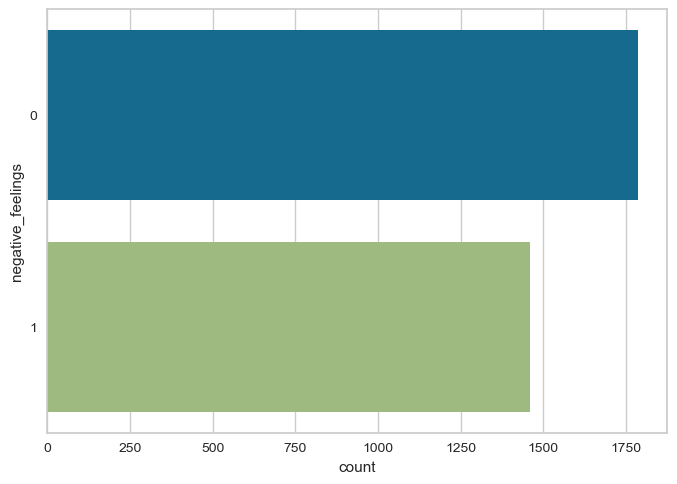

In [69]:
sns.countplot(y="negative_feelings", data=train_data)

<AxesSubplot: xlabel='count', ylabel='negative_feelings'>

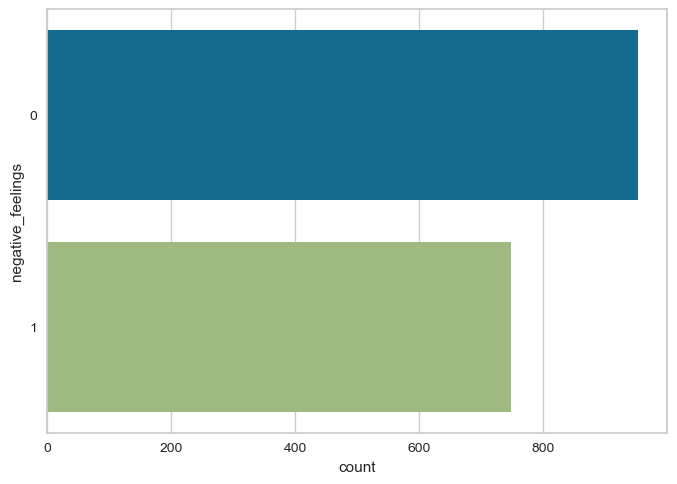

In [70]:
sns.countplot(y="negative_feelings", data=test_data)

In [71]:
fold_groups = train_data.id
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

In [72]:
s = setup(data=train_data, target='negative_feelings', silent=True, session_id=123, fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data)

,Description,Value
0,session_id,123
1,Target,negative_feelings
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(3245, 66)"
5,Missing Values,True
6,Numeric Features,42
7,Categorical Features,23
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='negative_feelings',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                n...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_

In [73]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5501,0.5274,0.0000,0.0000,0.0000,0.0000,0.0000,0.0533
dummy,Dummy Classifier,0.5501,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0467
rf,Random Forest Classifier,0.5442,0.5283,0.3170,0.4919,0.3794,0.0522,0.0552,0.1567
gbc,Gradient Boosting Classifier,0.5365,0.5186,0.3412,0.4844,0.3918,0.0437,0.0464,0.3533
ada,Ada Boost Classifier,0.5334,0.5076,0.3680,0.4781,0.4109,0.0376,0.0393,0.1367
et,Extra Trees Classifier,0.5300,0.5225,0.2830,0.4659,0.3383,0.0215,0.0226,0.1367
lightgbm,Light Gradient Boosting Machine,0.5297,0.5248,0.4116,0.4752,0.4324,0.0435,0.0441,0.2967
knn,K Neighbors Classifier,0.5248,0.5142,0.4298,0.4685,0.4475,0.0326,0.0326,0.0767
nb,Naive Bayes,0.5119,0.5280,0.5491,0.4708,0.4980,0.0336,0.0322,0.0500
dt,Decision Tree Classifier,0.5113,0.5073,0.4412,0.4541,0.4471,0.0074,0.0074,0.0600


create_model_container: 14
master_model_container: 14
display_container: 2
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
compare_models() succesfully completed......................................


Preprocessing steps added:
4. drop 'spo2', 'scl_avg'
5. replace outliers and NaNs with columns median

In [75]:
data = preprocessing_functions.post_preprocessing(data)

In [76]:
train_data, test_data = preprocessing_functions.train_test_split_per_user(data)
fold_groups = train_data.id
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

In [77]:
s = setup(data=train_data, target='negative_feelings', silent=True, session_id=123, fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data)

,Description,Value
0,session_id,123
1,Target,negative_feelings
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(3245, 64)"
5,Missing Values,False
6,Numeric Features,56
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='negative_feelings',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                n...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_

In [78]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5501,0.5296,0.0000,0.0000,0.0000,0.0000,0.0000,0.0167
dummy,Dummy Classifier,0.5501,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0133
rf,Random Forest Classifier,0.5415,0.5329,0.3279,0.4848,0.3881,0.0481,0.0496,0.1100
et,Extra Trees Classifier,0.5319,0.5294,0.2983,0.4673,0.3516,0.0266,0.0272,0.0967
gbc,Gradient Boosting Classifier,0.5285,0.5279,0.3379,0.4743,0.3773,0.0290,0.0318,0.2933
nb,Naive Bayes,0.5276,0.5390,0.4178,0.4839,0.4280,0.0415,0.0446,0.0133
lda,Linear Discriminant Analysis,0.5227,0.5186,0.2912,0.4648,0.3521,0.0046,0.0085,0.0200
ada,Ada Boost Classifier,0.5226,0.5107,0.3833,0.4655,0.4169,0.0238,0.0241,0.0933
ridge,Ridge Classifier,0.5196,0.0000,0.2409,0.4493,0.3007,-0.0079,-0.0066,0.0133
knn,K Neighbors Classifier,0.5146,0.5110,0.4068,0.4573,0.4295,0.0113,0.0115,0.0367


create_model_container: 14
master_model_container: 14
display_container: 2
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
compare_models() succesfully completed......................................


In [79]:
s = setup(data=train_data, target='negative_feelings', silent=True, session_id=123, fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data, normalize=True, normalize_method='robust')		

,Description,Value
0,session_id,123
1,Target,negative_feelings
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(3245, 64)"
5,Missing Values,False
6,Numeric Features,56
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='negative_feelings',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                n...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dumm

In [80]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.5501,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100
et,Extra Trees Classifier,0.5461,0.5341,0.2818,0.4981,0.3499,0.0487,0.0546,0.0933
svm,SVM - Linear Kernel,0.5365,0.0000,0.4714,0.4907,0.4712,0.0677,0.0700,0.0200
rf,Random Forest Classifier,0.5328,0.5307,0.3169,0.4707,0.3734,0.0310,0.0315,0.1133
lightgbm,Light Gradient Boosting Machine,0.5307,0.5190,0.3494,0.4732,0.3985,0.0322,0.0334,0.0733
dt,Decision Tree Classifier,0.5273,0.5282,0.3762,0.4653,0.4120,0.0308,0.0303,0.0200
gbc,Gradient Boosting Classifier,0.5257,0.5266,0.3371,0.4717,0.3755,0.0240,0.0269,0.2767
lr,Logistic Regression,0.5251,0.5117,0.2396,0.4600,0.3032,0.0026,0.0053,0.0567
qda,Quadratic Discriminant Analysis,0.5245,0.4756,0.2206,0.4480,0.2924,-0.0039,-0.0036,0.0133
lda,Linear Discriminant Analysis,0.5227,0.5186,0.2912,0.4648,0.3521,0.0046,0.0085,0.0200


create_model_container: 14
master_model_container: 14
display_container: 2
DummyClassifier(constant=None, random_state=123, strategy='prior')
compare_models() succesfully completed......................................


In [81]:
s = setup(data=train_data, target='negative_feelings', silent=True, session_id=123, fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data, normalize=True, normalize_method='minmax')

,Description,Value
0,session_id,123
1,Target,negative_feelings
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(3245, 64)"
5,Missing Values,False
6,Numeric Features,56
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='negative_feelings',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                n...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dumm

In [82]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.5501,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100
rf,Random Forest Classifier,0.5464,0.5316,0.3227,0.4923,0.3862,0.0568,0.0588,0.1100
svm,SVM - Linear Kernel,0.5307,0.0000,0.3171,0.4895,0.3039,0.0158,0.0266,0.0200
gbc,Gradient Boosting Classifier,0.5300,0.5288,0.3387,0.4755,0.3781,0.0319,0.0348,0.2767
et,Extra Trees Classifier,0.5288,0.5220,0.2697,0.4619,0.3259,0.0163,0.0170,0.1167
dt,Decision Tree Classifier,0.5279,0.5222,0.3698,0.4672,0.4086,0.0311,0.0308,0.0200
knn,K Neighbors Classifier,0.5245,0.5217,0.4658,0.4719,0.4663,0.0402,0.0406,0.1033
lda,Linear Discriminant Analysis,0.5227,0.5186,0.2912,0.4648,0.3521,0.0046,0.0085,0.0167
ada,Ada Boost Classifier,0.5226,0.5107,0.3833,0.4655,0.4169,0.0238,0.0241,0.0900
lr,Logistic Regression,0.5220,0.5111,0.2361,0.4494,0.2932,-0.0024,-0.0023,0.0267


create_model_container: 14
master_model_container: 14
display_container: 2
DummyClassifier(constant=None, random_state=123, strategy='prior')
compare_models() succesfully completed......................................
